<a href="https://colab.research.google.com/github/moharamfatema/graduation-project/blob/main/transfer_learning_transformer_movies_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1r_ElyehZwlWC7je1ZCsrauqKAObqnjNN?usp=sharing)

# Violence Detection In Movie Scenes

## Prepare the runtime

In [ ]:
!pip install colab-convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colab-convert: filename=colab_convert-2.0.5-py3-none-any.whl size=19224 sha256=6716d0924e59e731a6de2da4ff597d4d0eba818c33be6d5bac8a386c08ab2edd
  Stored in directory: /root/.cache/pip/wheels/04/f2/9d/ee946c8db91ba06736f0fc6d0391421f891d5e19785ce707f6
Successfully built colab-convert


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
!pip show colab-convert
print()
!pip show numpy
print()
!pip show tensorflow
print()
!pip show opencv-python
print()
!pip show pyyaml
print()
!pip show h5py

Name: colab-convert
Version: 2.0.5
Summary: Convert .py files runnable in VSCode/Python or Atom/Hydrogen to jupyter/colab .ipynb notebooks and vice versa
Home-page: https://github.com/MSFTserver/colab-convert
Author: HostsServer
Author-email: msftserver@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: json5
Required-by: 

Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, xarray-einstats, wordcloud, torchvision, torchtext, tifffile, thinc, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, scikit-image, resampy, qudida, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc, pyerfa, pyemd

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes'
%ls -a

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1lB9yrEkShjexDmBZKReu7bjw8lfmUnmH/automatic-detection-of-violence-in-video-scenes
cc-outputs.log    .git/               MViTv2_L_40x3_k400_f306903192.pyth
Combined/         .gitignore          new_repo.sh
config_user.sh    git_interactive.py  requirements.txt
convert.txt       Hockey@             svm_model.pkl
Crowd2@           info.txt            sync.sh
forest_model.pkl  Movies/             transformers/


### Imports

In [ ]:
import tensorflow as tf
from tensorflow      import keras
from keras           import layers as tfl
from keras.callbacks import EarlyStopping
from keras.backend   import clear_session
from tensorflow_docs.vis import embed

import os
import numpy as np
import cv2 
import datetime
import imageio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

''

## Data Preprocessing

### Define Constants

In [ ]:
# define input paths

ROOT_PATH = '/content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes'
MOVIES_PATH = ROOT_PATH + '/Movies/Movies Fight Dataset'

VIOLENCE_PATH = MOVIES_PATH + '/Violence'
NORMAL_PATH = MOVIES_PATH + '/Normal'

print(os.listdir(NORMAL_PATH)[-1])
print(os.listdir(VIOLENCE_PATH)[-1])

# define output paths

OUT_PATH = ROOT_PATH + '/transformers/preprocessed_data'


60.mpg
newfi67.avi


### Process raw data

In [ ]:
IMG_SIZE = 50

def load_video(path, max_frames=0, dimension=IMG_SIZE):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        i = -1
        while True:
            i += 1
            if i % 2 != 0:
                continue
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (dimension, dimension), interpolation = cv2.INTER_AREA)
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [ ]:
def build_feature_extractor(dimension=IMG_SIZE):
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(dimension, dimension,3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((dimension, dimension,3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [ ]:
feature_extractor = build_feature_extractor()

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 50




def prepare_all_videos(df, root_dir=MOVIES_PATH):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["label"].values

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir,NORMAL_PATH if labels[idx]==0 else VIOLENCE_PATH, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [ ]:
def process_paths(normal, violence):
  subset = min(len(normal),len(violence))

  y = np.concatenate([np.zeros(subset), np.ones(subset)])
  x = np.concatenate([normal[:subset], violence[:subset]], axis = 0)

  print((x.shape, y.shape))

  #shuffle
  per = np.random.permutation(len(x))

  x = x[per]
  y = y[per]
  y = y.astype(int)

  y = np.expand_dims(y, -1)

  return x, y

In [ ]:
def save_datasets(
    save_path: str
  ) -> np.ndarray:
  
  normal_random = np.random.permutation(100)
  violence_random = np.random.permutation(100)

  # train
  normal_data = np.array(os.listdir(f'{MOVIES_PATH}/Normal'))[normal_random[:70]]
  violence_data = np.array(os.listdir(f'{MOVIES_PATH}/Violence'))[violence_random[:70]]

  x, y = process_paths(normal_data, violence_data)

  del normal_data
  del violence_data

  x = x.reshape(-1)
  y = y.reshape(-1)

  data_dict = {
    "video_name":x,
    "label":y,
  }

  df = pd.DataFrame.from_dict(data_dict)

  x, y = prepare_all_videos(df)

  del df
  del data_dict

  np.save(f'{save_path}/x_train',x)
  np.save(f'{save_path}/y_train',y)

  del x
  del y

  # validation
  normal_data = np.array(os.listdir(f'{MOVIES_PATH}/Normal'))[normal_random[70:85]]
  violence_data = np.array(os.listdir(f'{MOVIES_PATH}/Violence'))[violence_random[70:85]]

  x, y = process_paths(normal_data, violence_data)

  del normal_data
  del violence_data

  x = x.reshape(-1)
  y = y.reshape(-1)

  data_dict = {
    "video_name":x,
    "label":y,
  }

  df = pd.DataFrame.from_dict(data_dict)

  x, y = prepare_all_videos(df)

  del df
  del data_dict

  np.save(f'{save_path}/x_val',x)
  np.save(f'{save_path}/y_val',y)

  del x
  del y

  # test
  normal_data = np.array(os.listdir(f'{MOVIES_PATH}/Normal'))[normal_random[85:]]
  violence_data = np.array(os.listdir(f'{MOVIES_PATH}/Violence'))[violence_random[85:]]

  x, y = process_paths(normal_data, violence_data)

  del normal_data
  del violence_data

  x = x.reshape(-1)
  y = y.reshape(-1)

  data_dict = {
    "video_name":x,
    "label":y,
  }

  df = pd.DataFrame.from_dict(data_dict)

  x, y = prepare_all_videos(df)

  del df
  del data_dict

  np.save(f'{save_path}/x_test',x)
  np.save(f'{save_path}/y_test',y)

  del x
  del y

In [ ]:
# save_datasets(OUT_PATH)

### Load presaved and preprocessed data

In [ ]:
# Load Data

def load_x_y(
    load_which: str = 'train', 
  ):
  violence_data = None
  normal_data = None

  if load_which == 'train':
    x = np.load(f'{OUT_PATH}/x_train.npy')
    y  = np.load(f'{OUT_PATH}/y_train.npy')

  elif load_which == 'validation':
    x = np.load(f'{OUT_PATH}/x_val.npy')
    y  = np.load(f'{OUT_PATH}/y_val.npy')

  elif load_which == 'test':
    x = np.load(f'{OUT_PATH}/x_test.npy')
    y  = np.load(f'{OUT_PATH}/y_test.npy')

  print(f'y shape = {y.shape}')
  print(f'x shape = {x.shape}')

  return x, y

In [ ]:
x_train, y_train = load_x_y('train')

x_val, y_val = load_x_y('validation')

x_test, y_test = load_x_y('test')


y shape = (140,)
x shape = (140, 20, 1024)
y shape = (30,)
x shape = (30, 20, 1024)
y shape = (30,)
x shape = (30, 20, 1024)


#Model


In [ ]:
class PositionalEmbedding(tfl.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = tfl.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [ ]:
class TransformerEncoder(tfl.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tfl.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [tfl.Dense(dense_dim, activation=tf.nn.gelu), tfl.Dense(embed_dim),]
        )
        self.layernorm_1 = tfl.LayerNormalization()
        self.layernorm_2 = tfl.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = 2

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = tfl.GlobalMaxPooling1D()(x)
    x = tfl.Dropout(0.5)(x)
    outputs = tfl.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = OUT_PATH
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        x_train,
        y_train,
        validation_data= (x_val, y_val),
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model, history

In [ ]:
EPOCHS = 40

In [ ]:
trained_model, history  = run_experiment()

Epoch 1/40
5/5 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.7500
Epoch 1: val_loss improved from inf to 0.07763, saving model to /content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes/transformers/preprocessed_data
5/5 [==============================] - 4s 535ms/step - loss: 1.0168 - accuracy: 0.7500 - val_loss: 0.0776 - val_accuracy: 0.9667
Epoch 2/40
5/5 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9500
Epoch 2: val_loss improved from 0.07763 to 0.03568, saving model to /content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes/transformers/preprocessed_data
5/5 [==============================] - 2s 446ms/step - loss: 0.2175 - accuracy: 0.9500 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 3/40
5/5 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9714
Epoch 3: val_loss did not improve from 0.03568
5/5 [==============================] - 2s 393ms/step - loss: 0.1522 - accuracy: 0.9

In [ ]:
trained_model.save(OUT_PATH+'/model')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
y_pred = trained_model.predict(x_test)

In [ ]:
print(y_pred.shape)
print(y_test.shape)

(30, 2)
(30,)


In [ ]:
y_pred = tf.argmax(y_pred, axis=-1)

In [ ]:
y_pred

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1])>

Logistic: ROC AUC=0.933
Best Threshold=1.000000, G-Mean=0.933


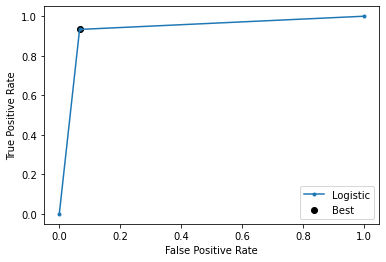

In [ ]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# keep probabilities for the positive outcome only
# calculate scores
ns_auc = roc_auc_score(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_pred)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('EER: %f' % EER)

EER: 0.066667


In [ ]:
#y_pred = [1 * (x[0]>=thresholds[ix]) for x in y_pred]
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

In [ ]:
con_mat

array([[14,  1],
       [ 1, 14]], dtype=int32)

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1], 
                     columns = [0,1])

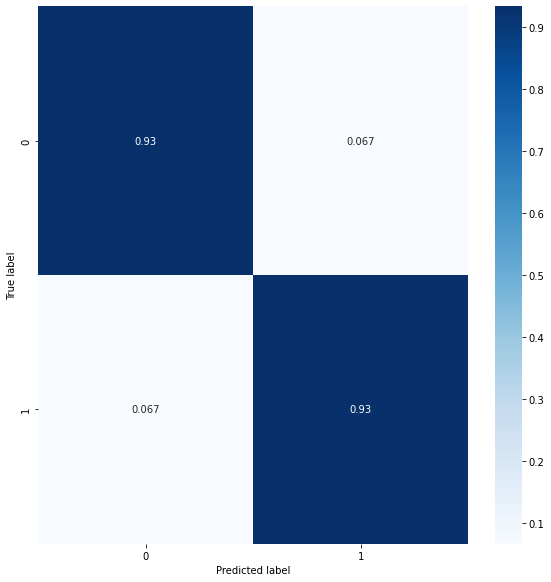

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')  
plt.xlabel('Predicted label')
plt.show()

In [ ]:
acc = (con_mat[0][0] + con_mat[1][1]) / (con_mat[0][0] + con_mat[0][1] + con_mat[1][0] + con_mat[1][1]) 
print('Accuracy when predicting based on best threshold: %f' % acc)

Accuracy when predicting based on best threshold: 0.933333
